# Import Library

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine

from sklearn.preprocessing import PowerTransformer # Change skew into normal
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data Load

In [45]:
df = pd.read_csv("data/Superstore.csv", encoding='windows-1252')

# Data Preprocessing

In [46]:
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [48]:
# Mengubah Data Type
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Postal Code'] = df['Postal Code'].astype(str)

In [49]:
# Membuat fitur baru Discount Amount 
df['Discount Amount'] = df['Sales'] * df['Discount']

In [50]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Discount Amount
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,0.000000
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,0.000000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,0.000000
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,430.909875
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,4.473600


In [51]:
# Mengambil beberapa informasi penting
main_df = df.groupby(by='Customer ID', as_index=False).agg({
    "Order Date": "max",
    "Ship Mode": (lambda x: x.mode()[0]),
    "Segment": (lambda x: x.mode()[0]),
    "Category": (lambda x: x.mode()[0]),
    "Region": (lambda x: x.mode()[0]),
    "Order ID": "nunique",
    "Sales": "sum",
    "Discount Amount": "sum"
})

main_df.head()

,Customer ID,Order Date,Ship Mode,Segment,Category,Region,Order ID,Sales,Discount Amount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [52]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Customer ID      793 non-null    object        
 1   Order Date       793 non-null    datetime64[ns]
 2   Ship Mode        793 non-null    object        
 3   Segment          793 non-null    object        
 4   Category         793 non-null    object        
 5   Region           793 non-null    object        
 6   Order ID         793 non-null    int64         
 7   Sales            793 non-null    float64       
 8   Discount Amount  793 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 55.9+ KB


In [53]:
main_df.columns = ['customer_id', 'max_order_timestamp', 'ship_mode', 'type_customers', 'category', 'region', 'frequency', 'monetary', 'discount']
main_df.head()

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [54]:
# Membuat kolom baru untuk Recency
main_df["max_order_timestamp"] = pd.to_datetime(main_df['max_order_timestamp'])
main_df["max_order_timestamp"] = main_df['max_order_timestamp'].dt.date  # Only take date without time
recent_date = df['Order Date'].dt.date.max()  # Take last date in dataset
main_df["recency"] = main_df['max_order_timestamp'].apply(lambda x: (recent_date - x).days)

main_df.head()

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415


# Exploratory Data Analysis


In [55]:
main_df.describe(include="all")

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
count,793,793,793,793,793,793,793.000000,793.000000,793.000000,793.000000
unique,793,300,4,3,3,4,NaN,NaN,NaN,NaN
top,ZD-21925,2017-12-02,Standard Class,Consumer,Office Supplies,East,NaN,NaN,NaN,NaN
freq,1,14,575,409,704,254,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.316520,2896.848500,406.787055,146.802018
std,NaN,NaN,NaN,NaN,NaN,NaN,2.550885,2628.670117,632.372871,186.211051
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.833000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1146.050000,102.691200,30.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,2256.394000,247.915600,75.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3785.276000,491.433300,183.000000


array([[<Axes: title={'center': 'frequency'}>,
        <Axes: title={'center': 'monetary'}>],
       [<Axes: title={'center': 'discount'}>,
        <Axes: title={'center': 'recency'}>]], dtype=object)

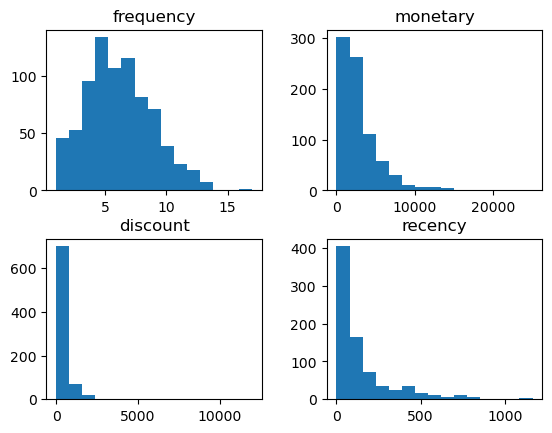

In [56]:
# Distribution of numerical features
numerical = ['frequency', 'monetary', 'discount', 'recency']
main_df[numerical].hist(bins=15, grid=False)

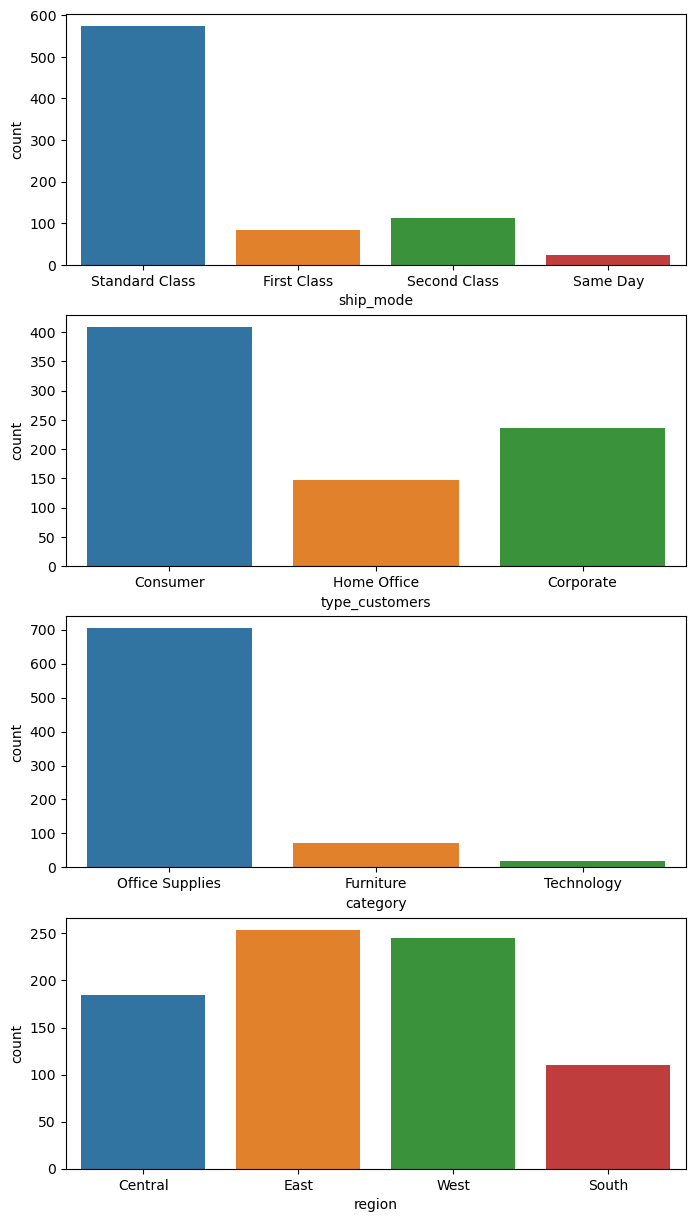

In [57]:
# Distribution of Categorical Features
categorical = ['ship_mode', 'type_customers', 'category', 'region']

fig, ax = plt.subplots(len(categorical), 1, figsize=(8,15))
for i, feature in enumerate(categorical):
    sns.countplot(data=main_df, x=feature, hue=feature, ax=ax[i])
plt.show()


In [58]:
# Distribution of customer type
# Helper function
def categorical_plot(features, df, segment_feature=None):
    fig, ax = plt.subplots(len(features), 1,figsize=(8,15))
    for i, feature in enumerate(features):
        if segment_feature:
            sns.countplot(data=df, x=segment_feature, hue=feature, ax=ax[i])
        else:
            sns.countplot(data=df, x=feature, ax=ax[i])
    plt.tight_layout()
    plt.show()

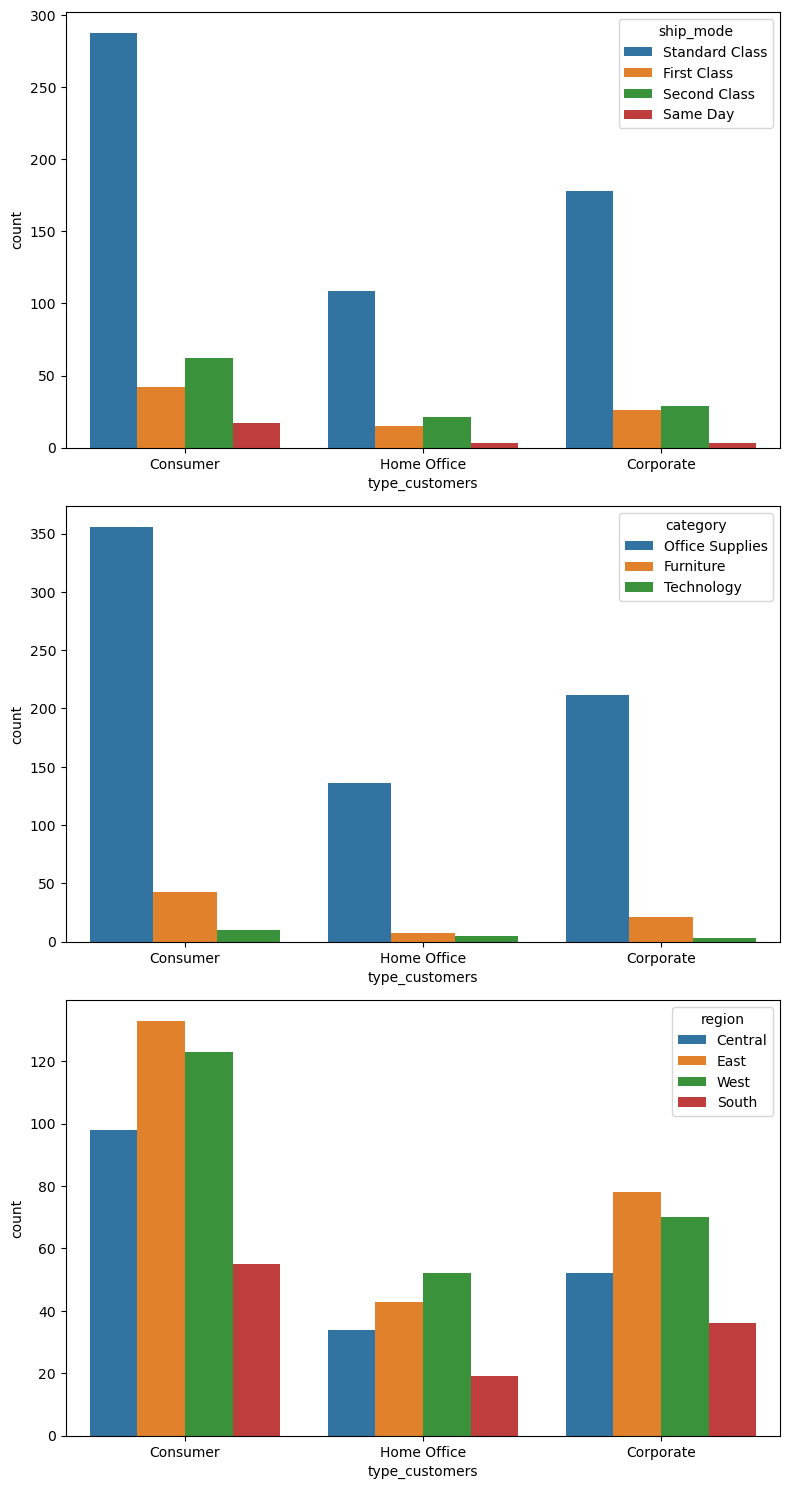

In [59]:
categorical_plot(
    features=['ship_mode', 'category', 'region'],
    df=main_df,
    segment_feature="type_customers"
)

In [60]:
# Distribution of categorical
def numerical_dis_plot(features, df, segment_feature=None, showfliers=True):
    fig, ax = plt.subplots(len(features), 1,figsize=(8,15))
    for i, feature in enumerate(features):
        if segment_feature:
            sns.boxplot(y=segment_feature, x=feature, data=df, ax=ax[i], showfliers=showfliers, palette="bright")
            ax[i].set_ylabel(None)
        else:
            sns.boxplot(x=feature, data=df, ax=ax[i], showfliers=showfliers)
    plt.tight_layout()
    plt.show()

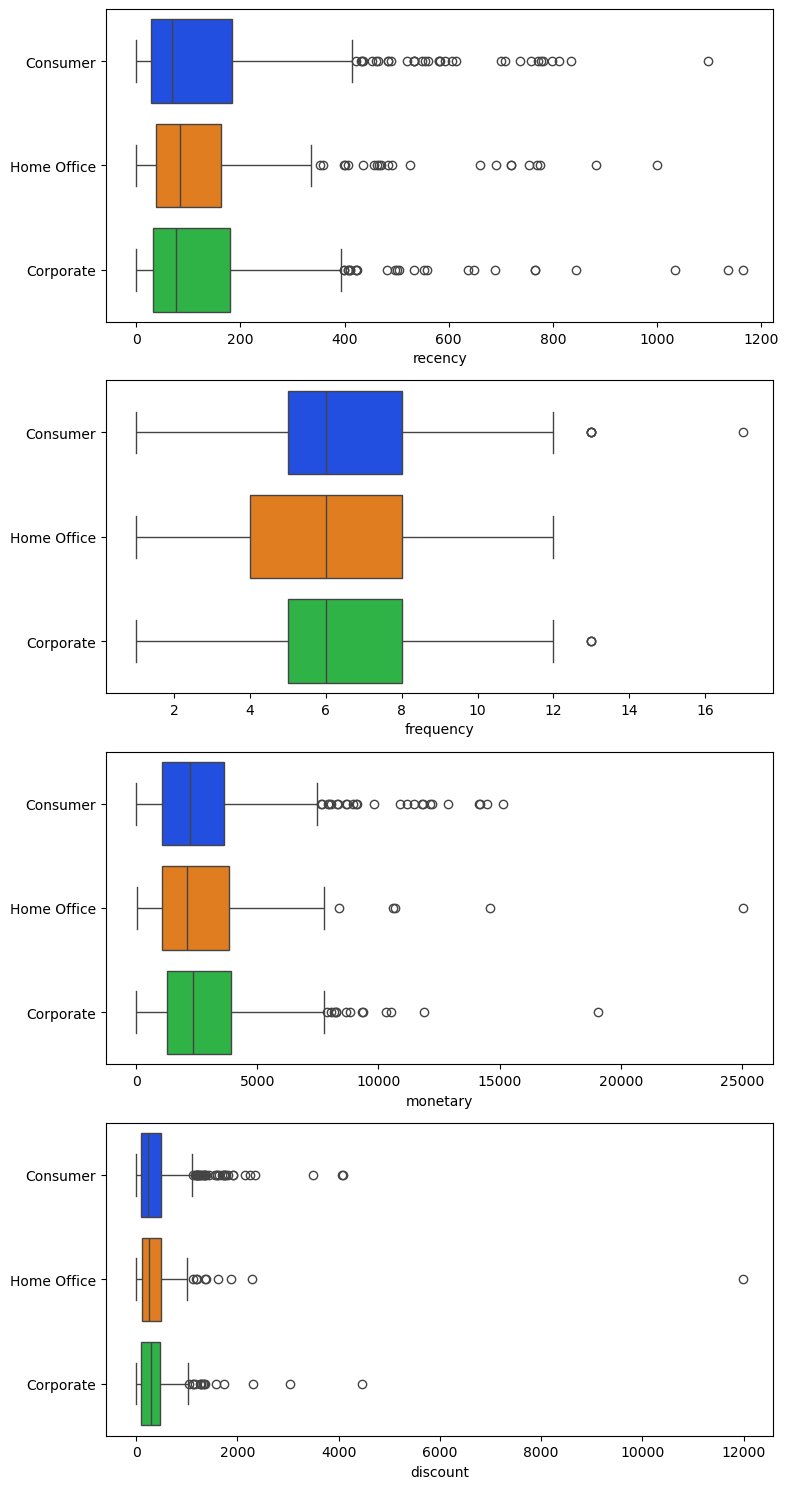

In [61]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=main_df, 
    segment_feature="type_customers"
)

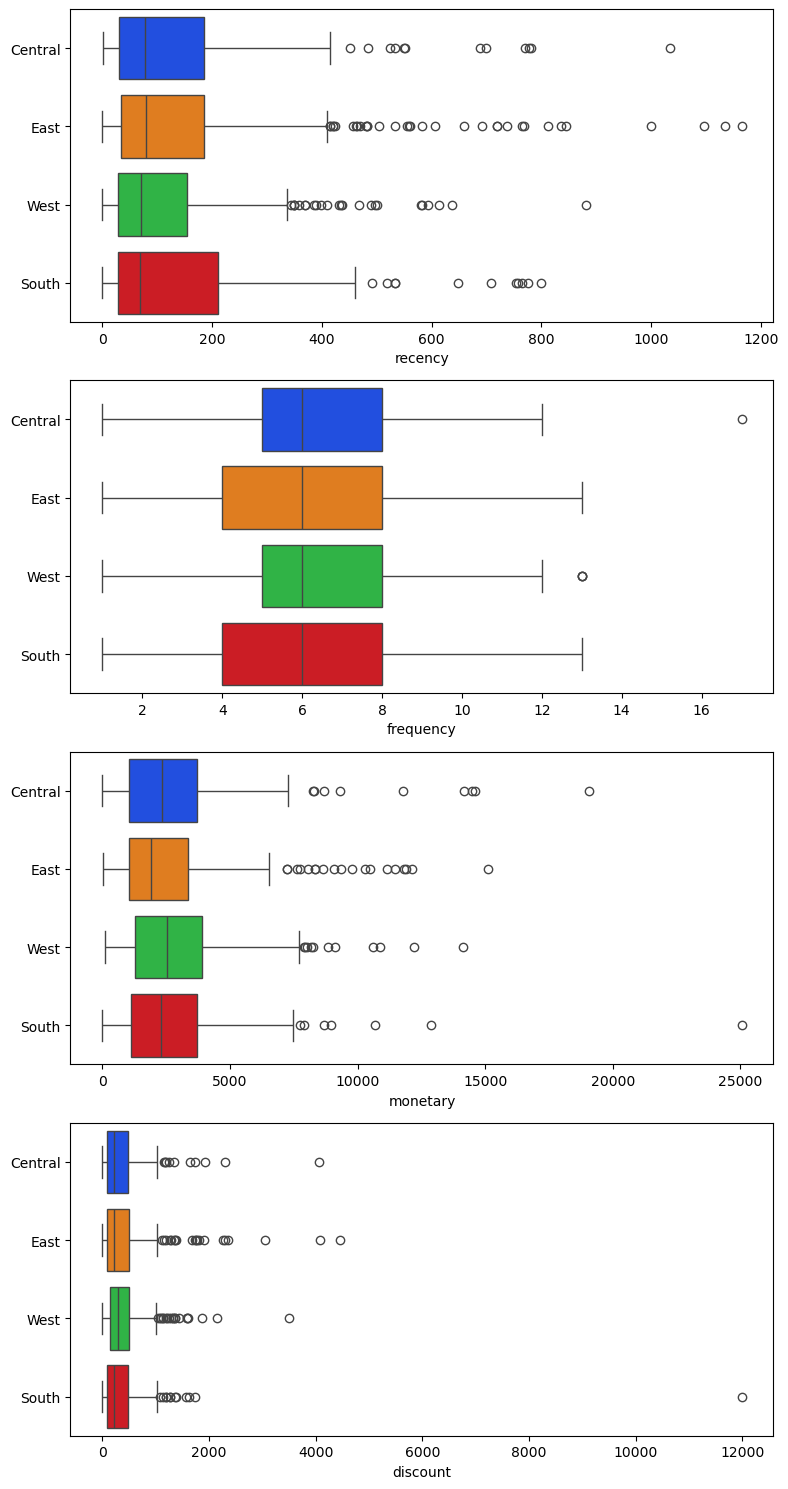

In [62]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=main_df, 
    segment_feature="region"
)

# RFM Analysis

In [63]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          793 non-null    object 
 1   max_order_timestamp  793 non-null    object 
 2   ship_mode            793 non-null    object 
 3   type_customers       793 non-null    object 
 4   category             793 non-null    object 
 5   region               793 non-null    object 
 6   frequency            793 non-null    int64  
 7   monetary             793 non-null    float64
 8   discount             793 non-null    float64
 9   recency              793 non-null    int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 62.1+ KB


In [64]:
rfm_df = main_df[['customer_id', 'recency', 'frequency', 'monetary']].copy()
rfm_df.head()

,customer_id,recency,frequency,monetary
0,AA-10315,184,5,5563.560
1,AA-10375,19,9,1056.390
2,AA-10480,259,4,1790.512
3,AA-10645,55,6,5086.935
4,AB-10015,415,3,886.156


In [65]:
# Score of RFM
rfm_df['r_score'] = rfm_df['recency'].rank(ascending=False)
rfm_df['f_score'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['m_score'] = rfm_df['monetary'].rank(ascending=True)

rfm_df.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score
0,AA-10315,184,5,5563.560,195.5,262.5,702.0
1,AA-10375,19,9,1056.390,685.5,670.0,182.0
2,AA-10480,259,4,1790.512,140.0,147.5,323.0
3,AA-10645,55,6,5086.935,463.5,383.0,679.0
4,AB-10015,415,3,886.156,71.5,73.0,142.0


In [66]:
# Normalization in percent
rfm_df['r_score_norm'] = (rfm_df['r_score']/rfm_df['r_score'].max()*100)
rfm_df['f_score_norm'] = (rfm_df['f_score']/rfm_df['f_score'].max()*100)
rfm_df['m_score_norm'] = (rfm_df['m_score']/rfm_df['m_score'].max()*100)

rfm_df.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,r_score_norm,f_score_norm,m_score_norm
0,AA-10315,184,5,5563.560,195.5,262.5,702.0,24.699937,33.102144,88.524590
1,AA-10375,19,9,1056.390,685.5,670.0,182.0,86.607707,84.489281,22.950820
2,AA-10480,259,4,1790.512,140.0,147.5,323.0,17.687934,18.600252,40.731400
3,AA-10645,55,6,5086.935,463.5,383.0,679.0,58.559697,48.297604,85.624212
4,AB-10015,415,3,886.156,71.5,73.0,142.0,9.033481,9.205549,17.906683


Weight of RFM Score:
- 20% of recency score
- 30% of frequency score
- 50% of monetary score


In [67]:
rfm_df['RFM_score'] = (0.2*rfm_df['r_score_norm'] + 0.3*rfm_df['f_score_norm'] + 0.5*rfm_df['m_score_norm']) * 0.05
rfm_df['RFM_score'].head()

0    2.956646
1    2.707187
2    1.474168
3    3.450666
4    0.676085
Name: RFM_score, dtype: float64

In [68]:
# Helper function
def rfm_score(df):
    df = df.copy()
    
    # Calculate the rank
    df['r_score'] = df['recency'].rank(ascending=False)
    df['f_score'] = df['frequency'].rank(ascending=True)
    df['m_score'] = df['monetary'].rank(ascending=True)
    
    # normalizing the rank of the customers
    df['r_score_norm'] = (df['r_score']/df['r_score'].max())*100
    df['f_score_norm'] = (df['f_score']/df['f_score'].max())*100
    df['m_score_norm'] = (df['m_score']/df['m_score'].max())*100
    
    # Calculate the RFM score
    df['RFM_score'] = (0.2*df['r_score_norm'] + 0.3*df['f_score_norm'] + \
        0.5*df['m_score_norm']) * 0.05
    df = df.round(2)
    
    return df

In [69]:
rfm_df = rfm_score(rfm_df)
rfm_df.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,r_score_norm,f_score_norm,m_score_norm,RFM_score
0,AA-10315,184,5,5563.56,195.5,262.5,702.0,24.70,33.10,88.52,2.96
1,AA-10375,19,9,1056.39,685.5,670.0,182.0,86.61,84.49,22.95,2.71
2,AA-10480,259,4,1790.51,140.0,147.5,323.0,17.69,18.60,40.73,1.47
3,AA-10645,55,6,5086.93,463.5,383.0,679.0,58.56,48.30,85.62,3.45
4,AB-10015,415,3,886.16,71.5,73.0,142.0,9.03,9.21,17.91,0.68


In [70]:
# Segmentation of Customers
rfm_df['customer_segment'] = np.where(
    rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.9), "Top Customers", (np.where(
        rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.75), "High Value Customers", (np.where(
            rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.25), "Medium Value Customers", "Low Value Customers"
        ))
    ))
)

rfm_df[['customer_id', 'RFM_score', 'customer_segment']].head()

,customer_id,RFM_score,customer_segment
0,AA-10315,2.96,Medium Value Customers
1,AA-10375,2.71,Medium Value Customers
2,AA-10480,1.47,Low Value Customers
3,AA-10645,3.45,High Value Customers
4,AB-10015,0.68,Low Value Customers


In [71]:
# Merge 
result_rfm_df = pd.merge(
    left=main_df,
    right=rfm_df[["customer_id", "RFM_score", "customer_segment"]],
    on="customer_id",
    how="inner"
)
result_rfm_df.head()

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency,RFM_score,customer_segment
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184,2.96,Medium Value Customers
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19,2.71,Medium Value Customers
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259,1.47,Low Value Customers
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55,3.45,High Value Customers
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415,0.68,Low Value Customers


In [72]:
result_rfm_df['customer_segment'].head()

0    Medium Value Customers
1    Medium Value Customers
2       Low Value Customers
3      High Value Customers
4       Low Value Customers
Name: customer_segment, dtype: object

<Axes: xlabel='count', ylabel='customer_segment'>

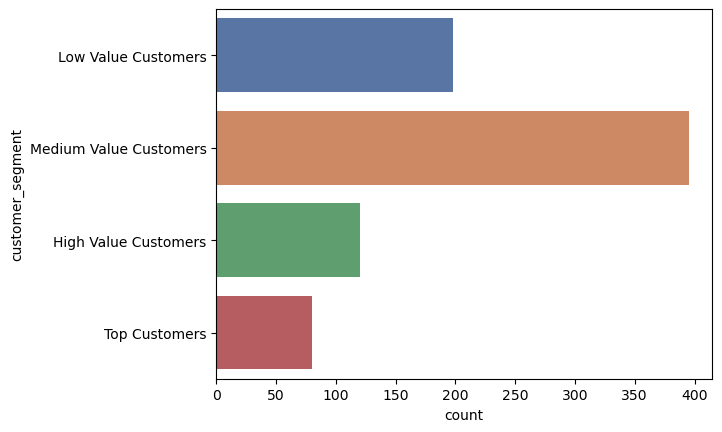

In [73]:
# Order category value
result_rfm_df['customer_segment'] = pd.Categorical(result_rfm_df['customer_segment'], 
                                                  ["Low Value Customers", "Medium Value Customers", "High Value Customers", "Top Customers"])

sns.countplot(data=result_rfm_df, y='customer_segment', palette="deep") 

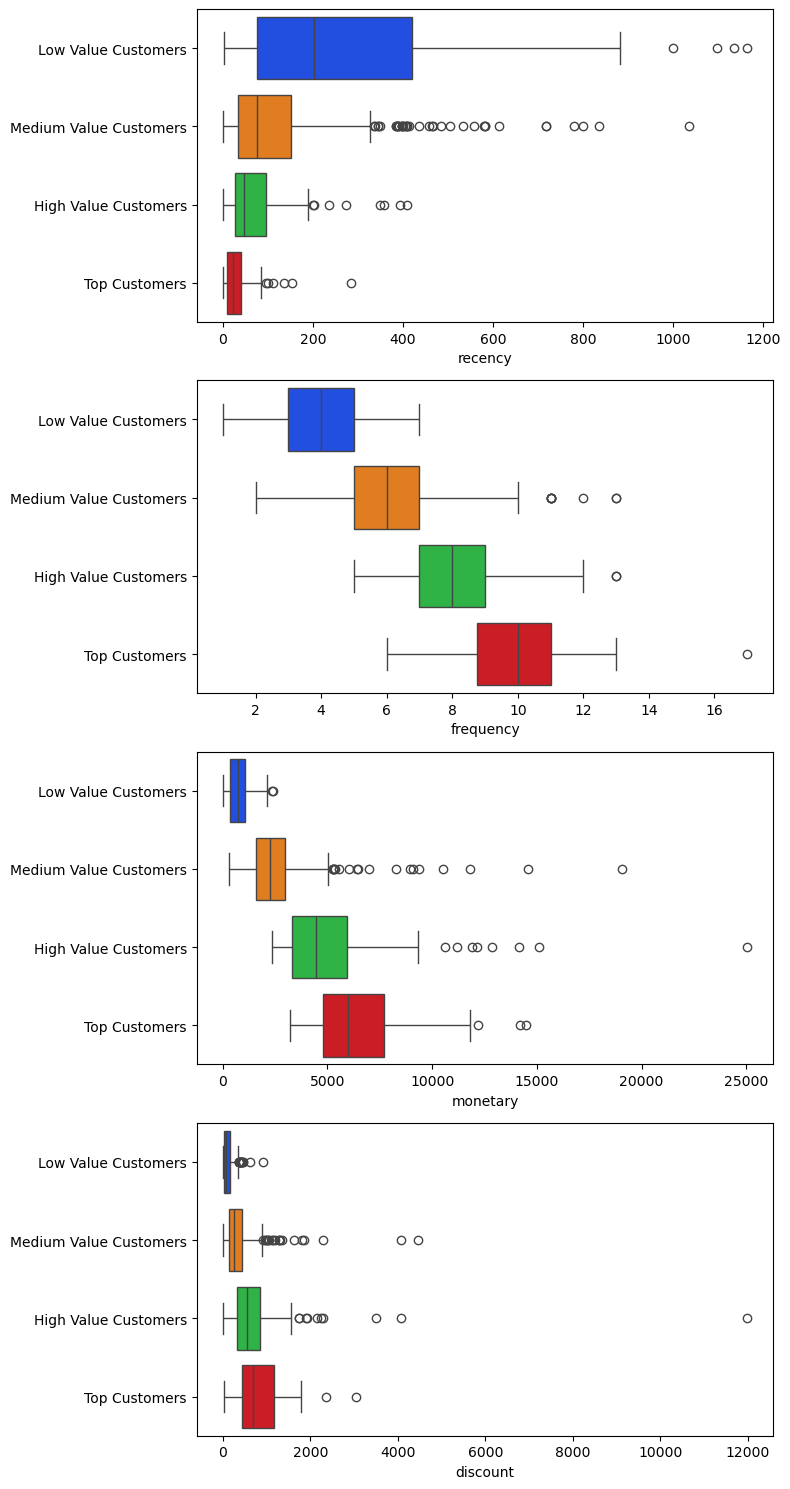

In [74]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=result_rfm_df, 
    segment_feature="customer_segment"
)

**Insight**:

Based on the graph above, there are quite clear pattern across each customer groups. One such pattern is total discount. The total discount used by group of Top customers and High value customes is greater than other groups. These discount could potentially be a lure to encourage to the Medium value customers to make more transaction and become High value customers.

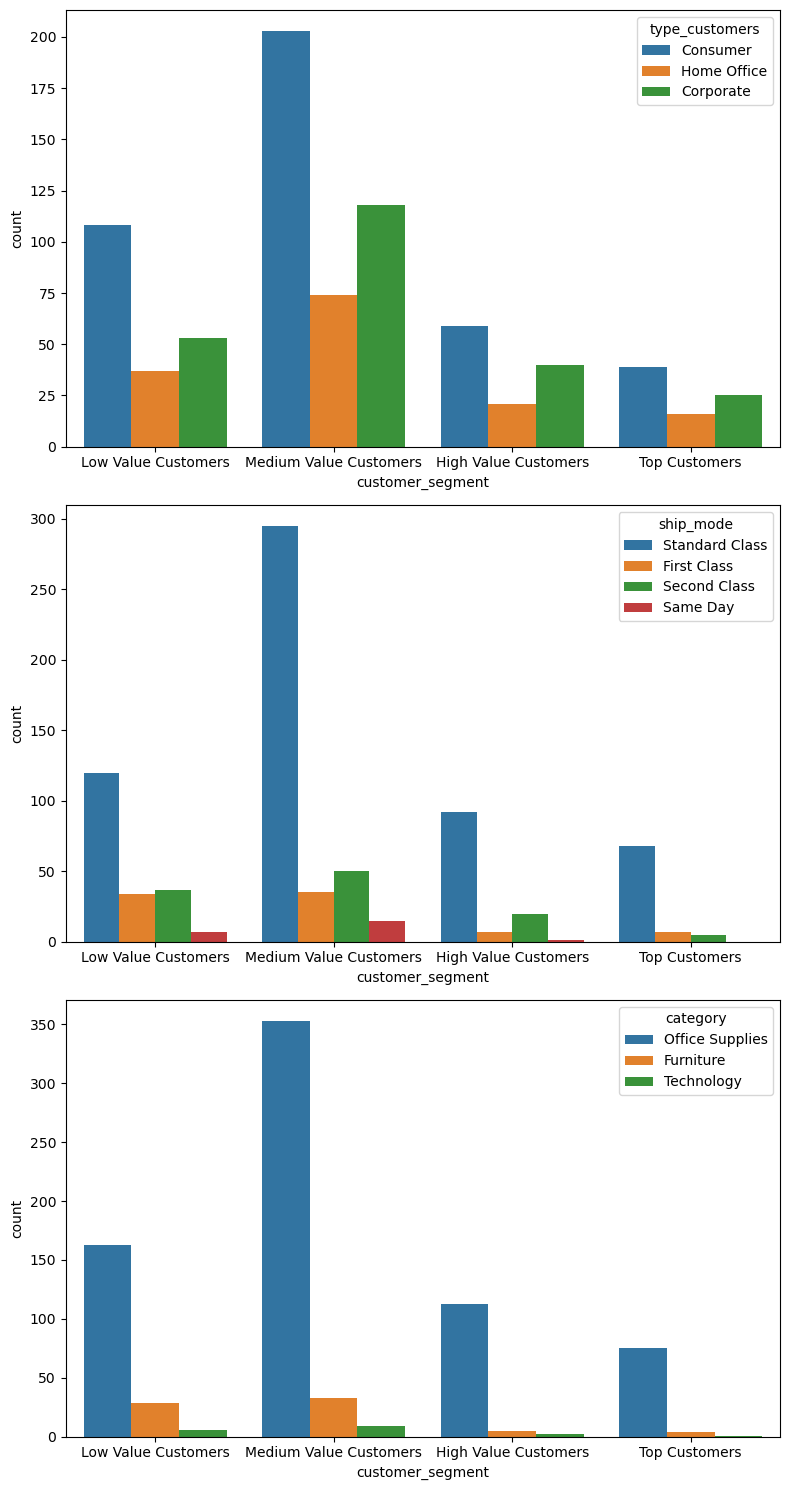

In [75]:
categorical_plot(
    features=["type_customers", "ship_mode", "category"],
    df=result_rfm_df, 
    segment_feature="customer_segment"
)

**Insight**:

From the categorical graph, unfortunately, we can't see interesting pattern there.

# Modelling

In [76]:
# Using KMeans
kmeans_df = main_df[["customer_id", "recency", "frequency", "monetary", "discount"]]
kmeans_df.head()

,customer_id,recency,frequency,monetary,discount
0,AA-10315,184,5,5563.560,1015.92800
1,AA-10375,19,9,1056.390,34.54400
2,AA-10480,259,4,1790.512,3.11040
3,AA-10645,55,6,5086.935,532.18395
4,AB-10015,415,3,886.156,12.26720


In [77]:
# Change skew into gaussian(normal) distribution
def power_transforms(features, df):
    df = df[features]
    for feature in features:
        transformer = PowerTransformer(standardize=True)
        y = np.asanyarray(df[feature])
        y = y.reshape(-1, 1)
        transformer.fit(y)
        df["transform_{}".format(feature)] = transformer.transform(y)
        df.drop([feature], axis=1, inplace=True)
        joblib.dump(transformer, "transformer_{}.joblib".format(feature))
    return df

In [78]:
transformed_kmeans_df = power_transforms(
    features = ['recency', 'frequency', 'monetary', 'discount'],
    df = kmeans_df
)

transformed_kmeans_df.head()

,transform_recency,transform_frequency,transform_monetary,transform_discount
0,0.701552,-0.459931,1.142958,1.325414
1,-0.994117,1.046277,-0.719477,-1.177057
2,0.996872,-0.893752,-0.220629,-1.993385
3,-0.257312,-0.053650,1.018462,0.675151
4,1.422079,-1.363189,-0.869587,-1.602655


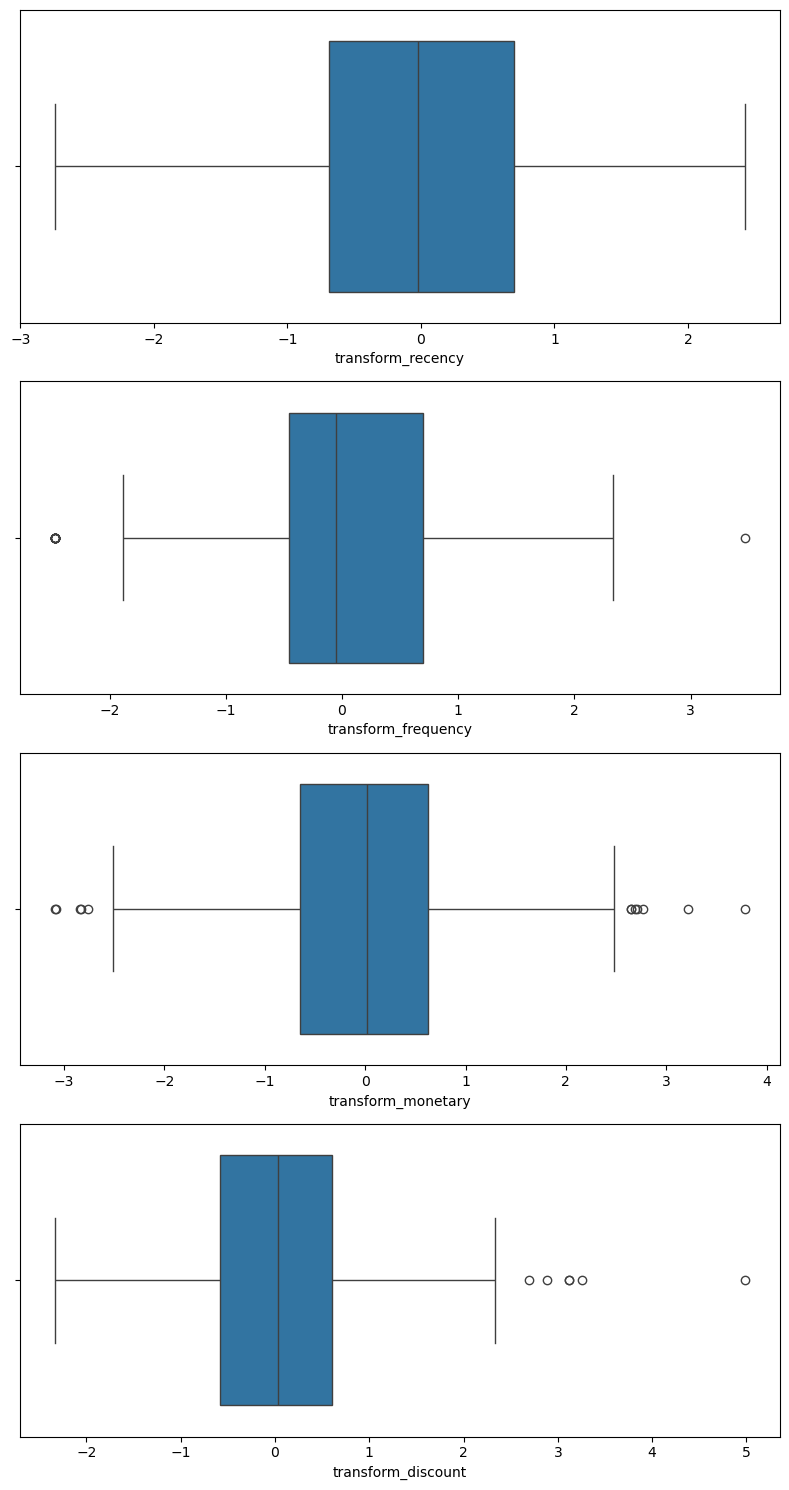

In [79]:
numerical_dis_plot(
    features=["transform_recency", "transform_frequency", "transform_monetary", "transform_discount"],
    df=transformed_kmeans_df,
)

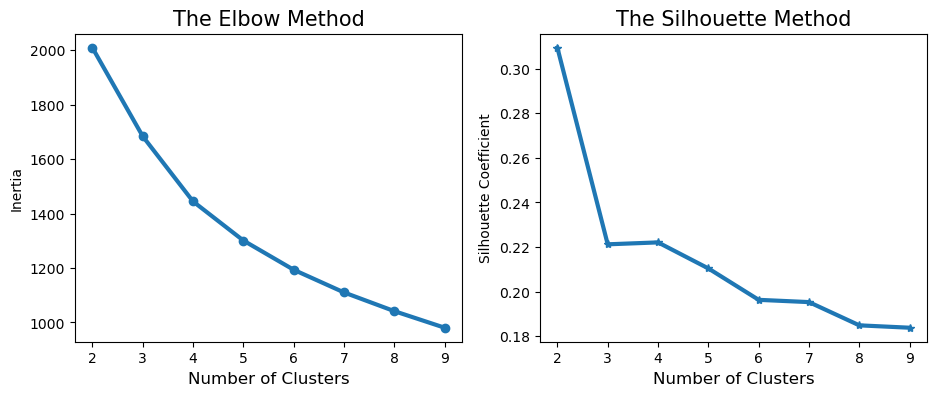

In [80]:
inertia = {}
silhouette = {}

for k in range (2,10):
    model = KMeans(n_clusters = k, random_state=75)
    model.fit_predict(transformed_kmeans_df)
    inertia[k] = model.inertia_ # Calculate the inertia
    silhouette[k] = silhouette_score(transformed_kmeans_df, model.labels_) # Calculate the silhouette coeff
    
fig, axs = plt.subplots(1,2, figsize=(11,4))
axs[0].plot(inertia.keys(), inertia.values(), marker= 'o', lw = 3)
axs[0].set_xlabel('Number of Clusters', fontsize = 12)
axs[0].set_ylabel('Inertia')
axs[0].set_title('The Elbow Method', fontsize = 15)
 
axs[1].plot(inertia.keys(), silhouette.values(), marker = '*' , lw = 3)
axs[1].set_xlabel('Number of Clusters', fontsize = 12)
axs[1].set_ylabel('Silhouette Coefficient')
axs[1].set_title('The Silhouette Method', fontsize = 15)
plt.show() 

**Insight**:
- inertia vs number of clusters = 4, when significantly decrease before it getting almost smaller
- silhouette coefficient vs number of cluster = 4 , find highest silhouette score 

In [81]:
K = 4

model = KMeans(n_clusters=K, random_state=75)
model.fit(transformed_kmeans_df)

joblib.dump(model, "kmeans_clustering_model.joblib")

['kmeans_clustering_model.joblib']

In [82]:
# Segment customers in 4 clusters
clusters = model.predict(transformed_kmeans_df)

kmeans_df['customer_segment'] = clusters.astype(str)
kmeans_df.sample(5)

,customer_id,recency,frequency,monetary,discount,customer_segment
552,NB-18580,1165,2,273.872,28.7904,3
513,MH-17785,98,7,2203.778,143.2016,2
654,RP-19855,28,8,2170.716,47.1262,2
470,LR-17035,132,5,1879.306,576.1722,1
210,DK-12835,21,12,3256.480,236.7320,0


In [83]:
result_kmeans_df = pd.merge(
    left=main_df,
    right=kmeans_df[["customer_id", "customer_segment"]],
    on="customer_id",
    how="inner"
)
result_kmeans_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency,customer_segment
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184,0
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19,2
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259,3
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55,0
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415,3


<Axes: xlabel='count', ylabel='customer_segment'>

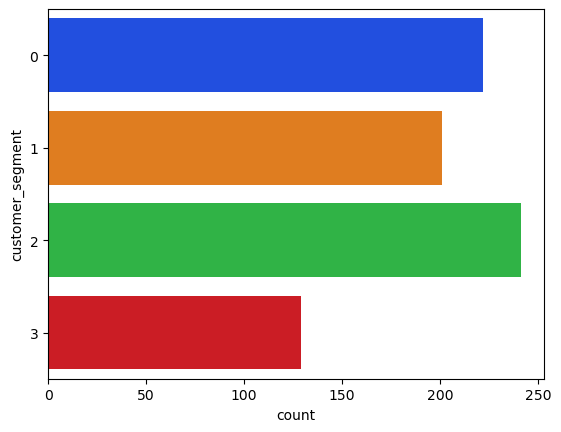

In [84]:
# Make order of customer segment
result_kmeans_df['customer_segment'] = pd.Categorical(result_kmeans_df['customer_segment'], 
                                                     ["0", "1", "2", "3"])

sns.countplot(data=result_kmeans_df, y='customer_segment', palette="bright")

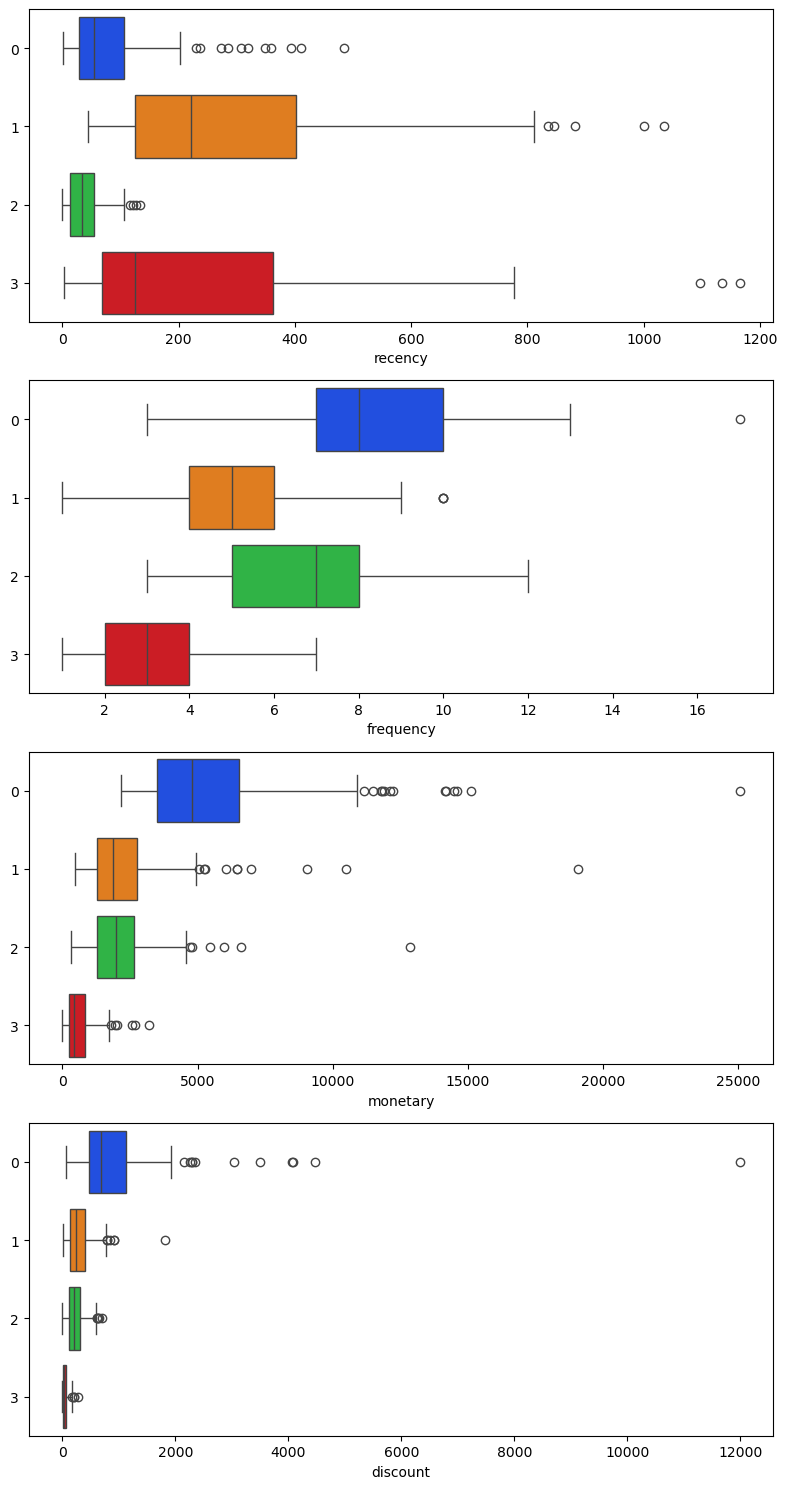

In [85]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
	df=result_kmeans_df, 
	segment_feature="customer_segment"
)

**Insight**:
- Cluster 0 merupakan kelompok pelanggan dengan Monetary (rata-rata $5k-$7k) dan Discount (rata-rata $500-$1k) tertinggi. Ini adalah cluster dengan jumlah pelanggan paling sedikit.
- Cluster 1 merupakan kelompok pelanggan dengan Recency terbaik (paling baru transaksi, e.g., 19 hari) dan Frequency tertinggi (e.g., 9 transaksi).
- Cluster 3 merupakan kelompok pelanggan dengan Recency terburuk (paling lama, e.g., 555 hari) dan Frequency terendah (e.g., 3 transaksi). Ini adalah cluster dengan jumlah pelanggan terbanyak.
- Cluster 2 merupakan kelompok pelanggan Medium/Low Value dengan Frequency dan Discount yang cenderung rendah.

**Result:**
- Cluster 0 → Top Customers (Loyal, Big Spenders, dapat diskon tinggi).
- Cluster 1 → High Value Customers (Sangat aktif, paling baru transaksi, berpotensi jadi Top Customer).
- Cluster 2 → Medium Value Customers (Nilainya standar).
- Cluster 3 → Cluster 3 → Low Value / At-Risk Customers (Jarang transaksi, sudah lama tidak kembali, nilai transaksi rendah).